In [10]:
import utils 
import numpy as np
import torch
import matplotlib.pyplot as plt

In [11]:
lcs = utils.get_data('synth_test_data', sep=',', min_length=10) 
net, optimizer, args, epoch, loss = utils.load_checkpoint('synth_2927074.h5', lcs.data_obj) # untrained

validated 41 files out of 41 for band='simband1'
created union_tp attribute of length 5068
dataset created w/ shape (40, 1, 180, 3)
train size: 32, valid size: 7, test size: 8


In [12]:
lcs.set_target_x(n=180)

In [13]:
def predict(dataloader, net, device='mps', k_iwae=2, subsample=False, target_x=None, plot=True, figsize=(25,15)):
    pred_mean, pred_std = [], []
    qz_mean, qz_std = [], []
    masks = []
    targets = []
    tp =[]
    target_tp = []
    np.random.seed(0)
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            batch_len = batch.shape[0]
            
            if subsample == True:
                subsampled_mask = utils.make_masks(batch, frac=0.5)
            else:
                subsampled_mask = utils.make_masks(batch, frac=1.0)
                
            batch = batch.to(device)
            subsampled_mask = subsampled_mask.to(device)
            recon_mask = torch.logical_xor(batch[:,:,:,1], subsampled_mask)
            context_y = torch.cat((batch[:,:,:,1] * subsampled_mask, subsampled_mask), 1).transpose(2,1)
            recon_context_y=torch.cat((batch[:,:,:,1] * recon_mask, recon_mask), 1).transpose(2,1)
            if target_x is not None:
                tx = torch.tensor(target_x[i*batch_len:(i*batch_len + batch_len)])[:,0]
            else:
                tx = batch[:, 0, :,0]

            px, qz = net.get_reconstruction(batch[:, 0, :,0], context_y, tx, num_samples=k_iwae)
            pred_mean.append(px.mean.cpu().numpy())
            pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
            qz_mean.append(qz.mean.cpu().numpy())
            qz_std.append(torch.exp(0.5 * qz.logvar).cpu().numpy())
            
            targets.append((batch[:, :, :,1]).cpu().numpy())
            masks.append(subsampled_mask.cpu().numpy())
            tp.append(batch[:, 0, :,0].cpu().numpy())
            target_tp.append(tx.cpu().numpy())
            
      
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    qz_mean = np.concatenate(qz_mean, axis=0)
    qz_std = np.concatenate(qz_std, axis=0)
    
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    target_tp = np.concatenate(target_tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    targets = np.transpose(targets, [0,2,1])
    inputs = np.transpose(inputs, [0,2,1])
    # reparam trick
    preds = np.random.randn(k_iwae//2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    
    qz_preds = np.random.randn(k_iwae//2, k_iwae, qz_mean.shape[0], qz_mean.shape[1], qz_mean.shape[2]) * qz_std + qz_mean
    qz_preds = qz_preds.reshape(-1, qz_mean.shape[0], qz_mean.shape[1], qz_mean.shape[2])
    qz_median = preds.mean(0)
    if plot == True:
        median = preds.mean(0)
        quantile2 = np.quantile(preds, 0.841, axis=0)
        quantile1 = np.quantile(preds, 0.159, axis=0)
        fig,ax = plt.subplots(5,1,figsize=figsize)
        for i in range(4):
            #### remove padding and masked vals
            nonzero_pred = target_tp[i].nonzero()[0]
            nonzero_in = inputs[i].nonzero()[0]
            nonzero_targets = targets[i].nonzero()[0]
            
            ax[i].fill_between(target_tp[i,nonzero_pred], quantile1[i,nonzero_pred,0], quantile2[i,nonzero_pred,0], label='error envelope',color='lightcoral')
            ax[i].errorbar(target_tp[i, nonzero_pred], median[i, nonzero_pred,0], yerr=(quantile2[i,nonzero_pred,0] - median[i, nonzero_pred,0]), c='blue', ecolor='#65c9f7', label='prediction')
            # conditoned on points
            #ax[i].scatter(tp[i, nonzero_in], inputs[i, nonzero_in], c='black', marker='x', zorder=30, label='conditioned on', s=100)
            # all points 
            ax[i].scatter(tp[i, nonzero_targets], targets[i, nonzero_targets], c='green', marker='.', s=100, zorder=100)       
    return qz_preds, tp, targets, inputs, target_tp, preds



(2, 32, 180, 1)


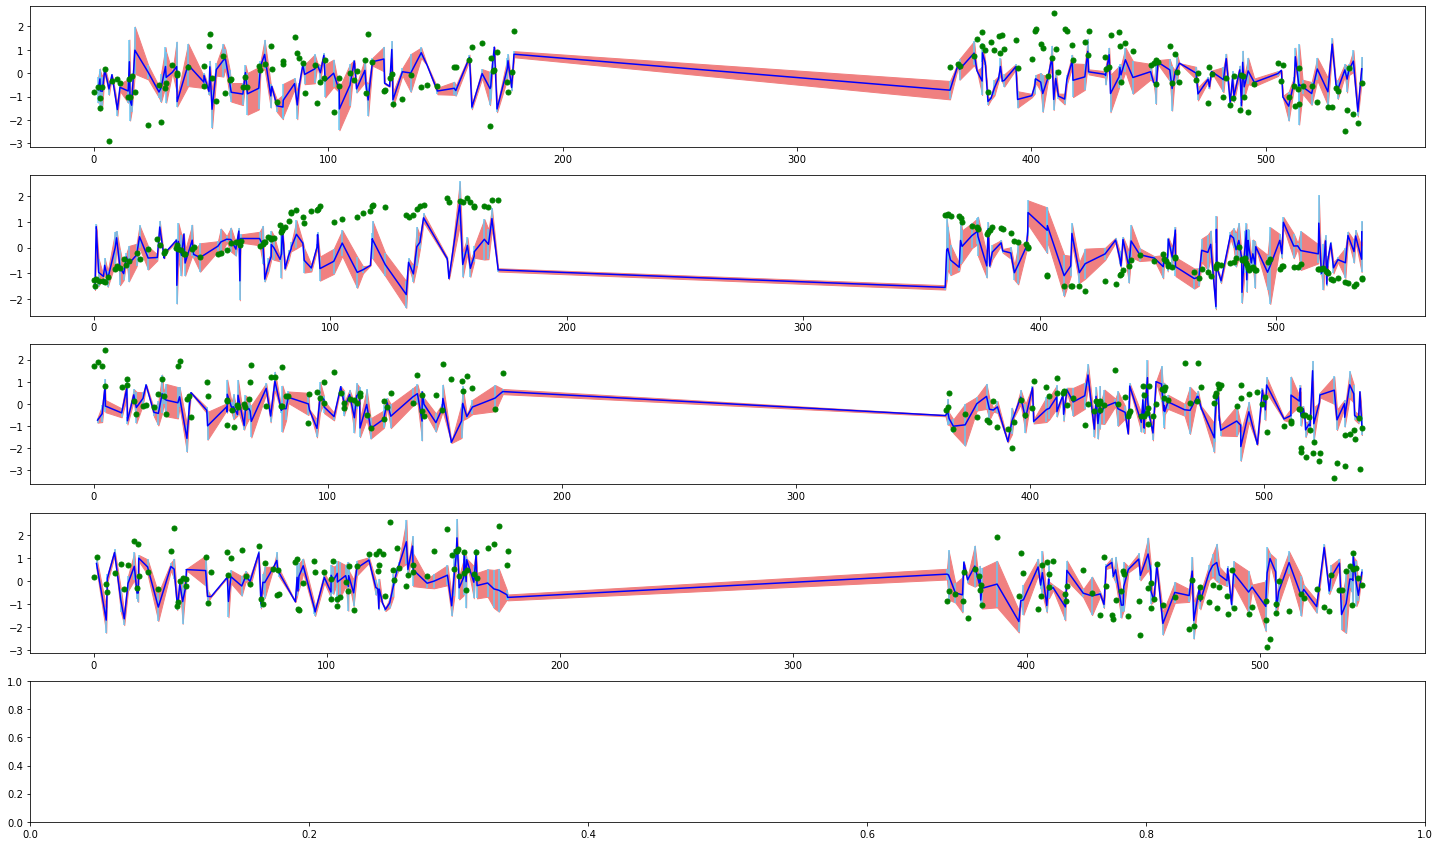

In [9]:
qz_preds, tp, targets, inputs, target_tp, preds = predict(lcs.data_obj['train_loader'], net, target_x=None, subsample=True)